In [7]:
!pip install torchtext

In [8]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import datasets
import tqdm

In [10]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

**Loading the dataset**

In [11]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [13]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [14]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [15]:
train_data.shape

(25000, 2)

Tokenization of words using *basic_english* from *torchtext*

In [16]:
import torchtext

In [17]:
tokenizer =  torchtext.data.utils.get_tokenizer("basic_english")

In [18]:
tokenizer("Hi there! What a beautiful morning")

['hi', 'there', '!', 'what', 'a', 'beautiful', 'morning']

**Tokenizing our dataset**

In [19]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [20]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [21]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [24]:
train_data[0]["text"]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [26]:
train_data[0]["label"]

0

In [27]:
train_data[0]["tokens"]

['i',
 'rented',
 'i',
 'am',
 'curious-yellow',
 'from',
 'my',
 'video',
 'store',
 'because',
 'of',
 'all',
 'the',
 'controversy',
 'that',
 'surrounded',
 'it',
 'when',
 'it',
 'was',
 'first',
 'released',
 'in',
 '1967',
 '.',
 'i',
 'also',
 'heard',
 'that',
 'at',
 'first',
 'it',
 'was',
 'seized',
 'by',
 'u',
 '.',
 's',
 '.',
 'customs',
 'if',
 'it',
 'ever',
 'tried',
 'to',
 'enter',
 'this',
 'country',
 ',',
 'therefore',
 'being',
 'a',
 'fan',
 'of',
 'films',
 'considered',
 'controversial',
 'i',
 'really',
 'had',
 'to',
 'see',
 'this',
 'for',
 'myself',
 '.',
 'the',
 'plot',
 'is',
 'centered',
 'around',
 'a',
 'young',
 'swedish',
 'drama',
 'student',
 'named',
 'lena',
 'who',
 'wants',
 'to',
 'learn',
 'everything',
 'she',
 'can',
 'about',
 'life',
 '.',
 'in',
 'particular',
 'she',
 'wants',
 'to',
 'focus',
 'her',
 'attentions',
 'to',
 'making',
 'some',
 'sort',
 'of',
 'documentary',
 'on',
 'what',
 'the',
 'average',
 'swede',
 'thought',


**We have converted our dataset into tokens of words stored in list using torchtext**

Creating validation set from training set

In [28]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [29]:
print(f"train set length : {len(train_data)}\t validation set length : {len(valid_data)}\t test set length : {len(test_data)}")

train set length : 18750	 validation set length : 6250	 test set length : 25000


# Creating a vocabulary

We use the *build_vocab_from_iterator* function from *torchtext.vocab* to create our vocabulary, specifying the min_freq (the minimum amount of times a token should appear to be added to the vocabulary) and special_tokens (tokens which should be appended to the start of the vocabulary, even if they don't appear min_freq times in the dataset).

### Special tokens


*   pad : used for pading sentences
*   unk : used for unknown tokens replacement


#### Rule of thumb - we will only store a token in our dictionary only if it appears more than *min_freq*




In [30]:
min_freq = 5
special_tokens = ["<unk>","<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials= special_tokens
)


In [31]:
len(vocab)

21635

In [34]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [35]:
vocab["a"]

5

In [36]:
## how to check if a token is in our dictionary vocab or not
"some_token" in vocab

False

In [37]:
# lets take the index of unk token and tab token as we'll need those ahead
unk_idx = vocab["<unk>"]
pad_idx = vocab["<pad>"]

In [38]:
print(f"unk_idx : {unk_idx}")
print(f"pad_idx : {pad_idx}")

unk_idx : 0
pad_idx : 1


In [39]:
# set the default return index of a token when a token is not present in vocab
vocab.set_default_index(unk_idx)

In [40]:
vocab["some_token"]

0

In [41]:
# to look up the index of a list of tokens
vocab.lookup_indices(["hello","world","hey","<pad>"])

[5516, 184, 1302, 1]

## Numericalising the data

Saving the token indices separately for further vectorization

In [49]:
len(train_data["label"])

18750

In [50]:
def get_indices(example, vocab):
  indices = vocab.lookup_indices(example["tokens"])
  return {"indices" : indices}

In [51]:
train_data = train_data.map(get_indices,fn_kwargs={"vocab" : vocab})
test_data = test_data.map(get_indices,fn_kwargs={"vocab" : vocab})
valid_data = valid_data.map(get_indices,fn_kwargs={"vocab" : vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

In [52]:
print(f"tokens : {train_data[0]['tokens']}")
print(f"indices : {train_data[0]['indices']}")

tokens : ['look', ',', 'this', 'is', 'quite', 'possibly', 'one', 'of', 'the', 'best', 'movies', 'america', 'has', 'to', 'offer', 'the', 'rest', 'of', 'the', 'world', '.', 'to', 'hate', 'this', 'movie', 'is', 'to', 'hate', 'freedom', 'itself', '.', 'i', 'remember', 'that', 'the', 'early', '80', "'", 's', 'were', 'a', 'time', 'of', 'uncertainty', '.', 'the', 'economy', 'was', 'weak', ',', 'communism', 'threatened', 'us', 'all', ',', 'and', 'nuclear', 'destruction', 'was', 'almost', 'a', 'certainty', '.', 'out', 'of', 'that', 'confusion', 'came', 'a', 'hero', ',', 'stroker', 'ace', '.', 'ned', 'beatty', "'", 's', 'performance', 'in', 'this', 'movie', 'showed', 'he', 'was', 'never', 'again', 'to', 'be', 'type', 'cast', 'as', 'a', 'one', 'dimensional', 'victim', 'in', 'the', 'wilderness', '.', 'his', 'triumph', 'is', 'an', 'inspiration', 'to', 'all', '.', 'the', 'on-screen', 'chemistry', 'between', 'burt', 'and', 'loni', 'draws', 'obvious', 'comparisons', 'to', 'brad', 'and', 'jennifer', '.

#### Converting labels and indices into pytorch tensors

In [53]:
train_data = train_data.with_format(type="torch",columns=["label","indices"])
test_data = test_data.with_format(type="torch",columns=["label","indices"])
valid_data = valid_data.with_format(type="torch",columns=["label","indices"])

## Creating Data loaders

In [55]:
def get_collate_function(pad_index):
  def collate_function(batch):
    batch_indices = [i["indices"] for i in batch]
    batch_indices = nn.utils.rnn.pad_sequence(
        batch_indices,padding_value=pad_index,batch_first=True
    )
    batch_label = [i["label"] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {"indices" : batch_indices, "label" : batch_label}
    return batch

  return collate_function



In [59]:
def get_data_loader(dataset,batch_size,pad_index,shuffle = False):
  collate_fn = get_collate_function(pad_index)
  data_loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size = batch_size,
      collate_fn = collate_fn,
      shuffle = shuffle
  )
  return data_loader

In [60]:
batch_size = 512

train_data_loader = get_data_loader(train_data,batch_size,pad_index=pad_idx,shuffle=True)
test_data_loader = get_data_loader(test_data,batch_size,pad_index=pad_idx)
valid_data_data_loader = get_data_loader(valid_data,batch_size,pad_index=pad_idx)


## Building the model

In [64]:
class NBoW(nn.Module):
  def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim, padding_idx=pad_idx)
    self.fc = nn.Linear(embedding_dim,output_dim)

  def forward(self,ids):
    embedded = self.embedding(ids)
    pooled = embedded.mean(dim=1)
    prediction = self.fc(pooled)
    return prediction

In [65]:
vocab_size  = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique("label"))

model = NBoW(vocab_size,embedding_dim,output_dim,pad_idx)

In [67]:
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_params(model)} trainable params")

The model has 6491102 trainable params


In [68]:
vectors = torchtext.vocab.GloVe()


.vector_cache/glove.840B.300d.zip: 2.18GB [06:54, 5.25MB/s]                            
100%|█████████▉| 2196016/2196017 [03:21<00:00, 10908.94it/s]


In [69]:
hello_vector = vectors.get_vecs_by_tokens("hello")

In [71]:
hello_vector.shape

torch.Size([300])

In [72]:
pretrained_embeddings = vectors.get_vecs_by_tokens(vocab.get_itos())

In [74]:
pretrained_embeddings.shape

torch.Size([21635, 300])

In [75]:
model.embedding.weight

Parameter containing:
tensor([[-0.1117, -0.4966,  0.1631,  ..., -0.5592, -0.4480, -0.6476],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7882, -1.6625, -0.7064,  ..., -1.5841, -0.3711, -1.2338],
        ...,
        [-0.1833,  0.2245, -0.3846,  ..., -0.8093, -1.5803,  2.2097],
        [ 0.8763, -0.4503, -0.3297,  ...,  1.0524, -0.3182, -0.0381],
        [-0.7596,  0.6286,  0.0057,  ..., -0.8484, -0.1224,  1.3181]],
       requires_grad=True)

In [76]:
pretrained_embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.1662,  0.2845,  0.4958,  ..., -0.5733, -0.4675, -0.0965],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2701,  0.6335,  0.2016,  ..., -0.4568,  0.5783, -0.5545]])

In [77]:
model.embedding.weight.data = pretrained_embeddings

In [78]:
optimizer = optim.Adam(model.parameters())

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [79]:
criterion = nn.CrossEntropyLoss()

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [81]:
device

device(type='cpu')

In [82]:
model = model.to(device)
criterion = criterion.to(device)

In [88]:
def train(data_loader,model,criterion,optimizer,device):
  model.train()
  epoch_losses = []
  epoch_accs = []
  for batch in tqdm.tqdm(data_loader,desc = "training..."):
    ids = batch["indices"].to(device)
    label = batch["label"].to(device)
    prediction = model(ids)
    loss = criterion(prediction,label)
    accuracy = get_accuracy(prediction, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
    epoch_accs.append(accuracy.item())

  return np.mean(epoch_losses),np.mean(epoch_accs)

In [85]:
def evaluate(data_loader,model,criterion,device):
  model.eval()
  epoch_losses = []
  epoch_accs = []
  with torch.no_grad():
    for batch in tqdm.tqdm(data_loader,desc = "evaluating..."):
      ids = batch["indices"].to(device)
      labels = batch["label"].to(device)
      prediction = model(ids)
      loss = criterion(prediction,labels)
      accuarcy = get_accuracy(prediction,labels)
      epoch_losses.append(loss.item())
      epoch_accs.append(accuarcy.item())
  return np.mean(epoch_losses),np.mean(epoch_accs)

In [86]:
def get_accuracy(prediction, label):
  batch_size,_ = prediction.shape
  predicted_classes = prediction.argmax(dim=-1)
  correct_predictions = predicted_classes.eq(label).sum()
  accuracy = correct_predictions/batch_size
  return accuracy

In [89]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)
for epoch in range(n_epochs):
  train_loss, train_acc = train(train_data_loader, model=model, criterion=criterion, optimizer=optimizer, device=device)
  valid_loss, valid_acc = evaluate(valid_data_data_loader, model, criterion, device)
  metrics["train_losses"].append(train_loss)
  metrics["train_acc"].append(train_acc)
  metrics["validation_losses"].append(valid_loss)
  metrics["validation_acc"].append(valid_acc)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), "nbow.pt")
  print(f"epoch : {epoch}")
  print(f"train_loss : {train_loss:.3f}, train_accuracy : {train_acc:.3f}")
  print(f"validation loss : {valid_loss:.3f} , validation accuracy : {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:01<00:00,  9.58it/s]


epoch : 0
train_loss : 0.678, train_accuracy : 0.638
validation loss : 0.659 , validation accuracy : 0.725


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.02it/s]


epoch : 1
train_loss : 0.633, train_accuracy : 0.738
validation loss : 0.606 , validation accuracy : 0.755


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.25it/s]


epoch : 2
train_loss : 0.569, train_accuracy : 0.776
validation loss : 0.542 , validation accuracy : 0.782


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  7.96it/s]


epoch : 3
train_loss : 0.497, train_accuracy : 0.817
validation loss : 0.477 , validation accuracy : 0.822


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


epoch : 4
train_loss : 0.432, train_accuracy : 0.850
validation loss : 0.427 , validation accuracy : 0.843


evaluating...: 100%|██████████| 13/13 [00:01<00:00,  8.11it/s]


epoch : 5
train_loss : 0.379, train_accuracy : 0.872
validation loss : 0.393 , validation accuracy : 0.850


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.03it/s]


epoch : 6
train_loss : 0.339, train_accuracy : 0.885
validation loss : 0.364 , validation accuracy : 0.862


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.27it/s]


epoch : 7
train_loss : 0.306, train_accuracy : 0.896
validation loss : 0.345 , validation accuracy : 0.867


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.18it/s]


epoch : 8
train_loss : 0.279, train_accuracy : 0.906
validation loss : 0.329 , validation accuracy : 0.873


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 10.05it/s]

epoch : 9
train_loss : 0.257, train_accuracy : 0.914
validation loss : 0.318 , validation accuracy : 0.878


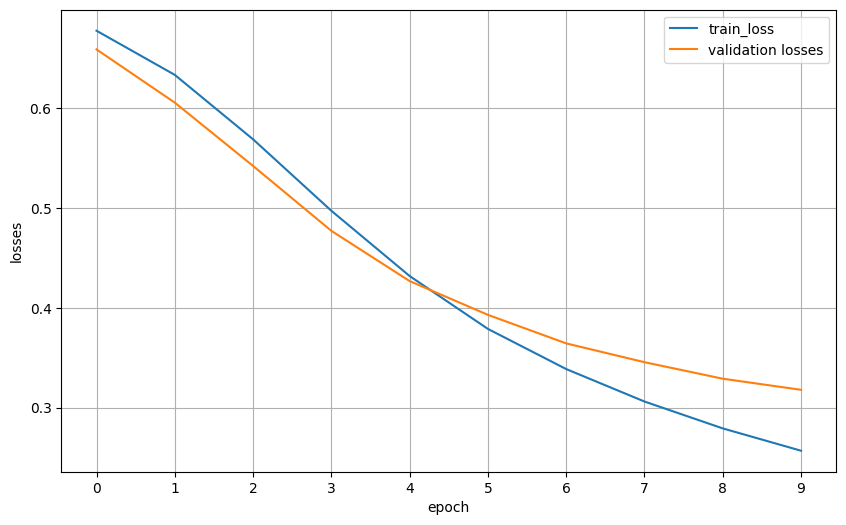

In [91]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(metrics["train_losses"], label = "train_loss")
ax.plot(metrics["validation_losses"], label = "validation losses")
ax.set_xlabel("epoch")
ax.set_ylabel("losses")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

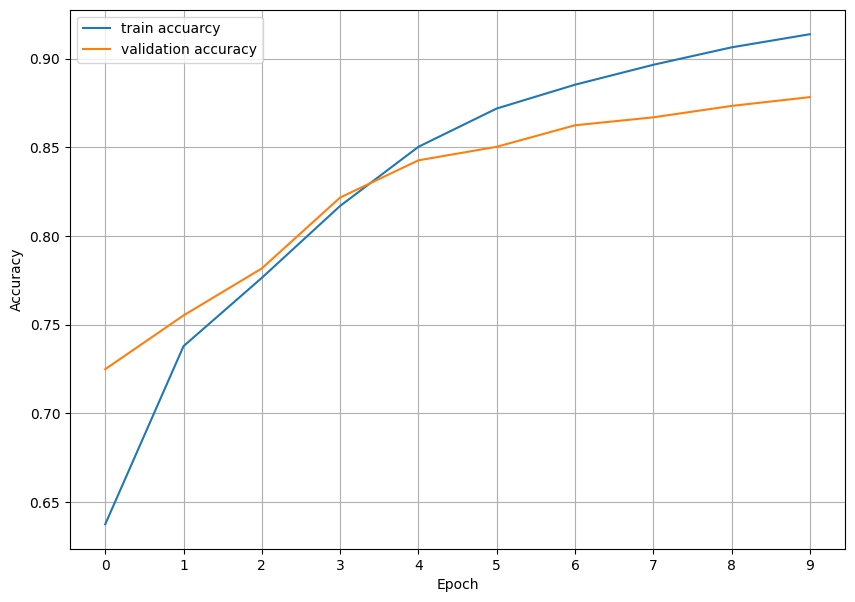

In [92]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
ax.plot(metrics["train_acc"], label="train accuarcy")
ax.plot(metrics["validation_acc"], label = "validation accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [93]:
model.load_state_dict(torch.load("nbow.pt"))

test_loss, test_acc = evaluate(test_data_loader,model,criterion,device)



evaluating...: 100%|██████████| 49/49 [00:05<00:00,  9.05it/s]


In [96]:
print(f"Test accuarcy : {test_acc:.3f}, test loss : {test_loss:.3f}")

Test accuarcy : 0.858, test loss : 0.352


In [99]:
def predict_sentiment(text,model, tokenizer, vocab, device):
  tokens = tokenizer(text)
  ids = vocab.lookup_indices(tokens=tokens)
  tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
  prediction = model(tensor).squeeze(dim=0)
  probability = torch.softmax(prediction, dim=-1)
  predicted_class = prediction.argmax(dim=-1).item()
  predicted_probability = probability[predicted_class].item()
  return predicted_class,predicted_probability

In [100]:
text = "This film is terrible"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9999998807907104)

In [101]:
text = "This film is awesome"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.999998927116394)

In [102]:
text = "Hey there! How you doing"

predict_sentiment(text, model, tokenizer, vocab, device)


(0, 0.9179787039756775)